# Phase 2 : Test de généralisation sur Bordeaux

### Objectif

Tester la robustesse et la capacité de généralisation des modèles construits sur **Lille**, en les appliquant à une autre ville : **Bordeaux**, pour les **logements de 4 pièces**, vendus en **2022**.

Deux cas seront analysés séparément :

- **Appartements uniquement**
- **Maisons uniquement**

### Consignes

1. **Charger les données de Bordeaux** depuis le fichier `data/bordeaux_2022.csv`.

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

data_bordeaux = pd.read_csv("../data/bordeaux_2022.csv")

# Afficher les 5 premières lignes
print("Aperçu des 5 premières lignes :")
print(data_bordeaux.head())

# Afficher les informations sur le DataFrame
print("\nInformations sur le DataFrame :")
print(data_bordeaux.info())

# Afficher les dimensions du DataFrame
print("\nDimensions du DataFrame (lignes, colonnes) :")
print(data_bordeaux.shape)

Aperçu des 5 premières lignes :
   Identifiant de document  Reference document  1 Articles CGI  \
0                      NaN                 NaN             NaN   
1                      NaN                 NaN             NaN   
2                      NaN                 NaN             NaN   
3                      NaN                 NaN             NaN   
4                      NaN                 NaN             NaN   

   2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   No disposition Date mutation Nature mutation  ...  Nombre de lots  \
0               1    04/01/2022           Vente  ...               0   
1           

2. **Appliquer exactement le même filtrage que pour Lille.**

Valeurs uniques du nombre de pièces :
[ 4.  1.  0.  3.  7.  2.  5.  6.  8. 10.  9. 11. 12. 15. 13.]

Nombre de biens par nombre de pièces :
Nombre pieces principales
0.0     6380
1.0     1302
2.0     1890
3.0     1734
4.0     1071
5.0      493
6.0      178
7.0       76
8.0       47
9.0       17
10.0       6
11.0       3
12.0       1
13.0       1
15.0       1
Name: count, dtype: int64

Nombre de biens de 4 pièces : 1071

Aperçu des biens de 4 pièces :
    Identifiant de document  Reference document  1 Articles CGI  \
0                       NaN                 NaN             NaN   
13                      NaN                 NaN             NaN   
23                      NaN                 NaN             NaN   
31                      NaN                 NaN             NaN   
48                      NaN                 NaN             NaN   

    2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
0              NaN             NaN             NaN             NaN   
13

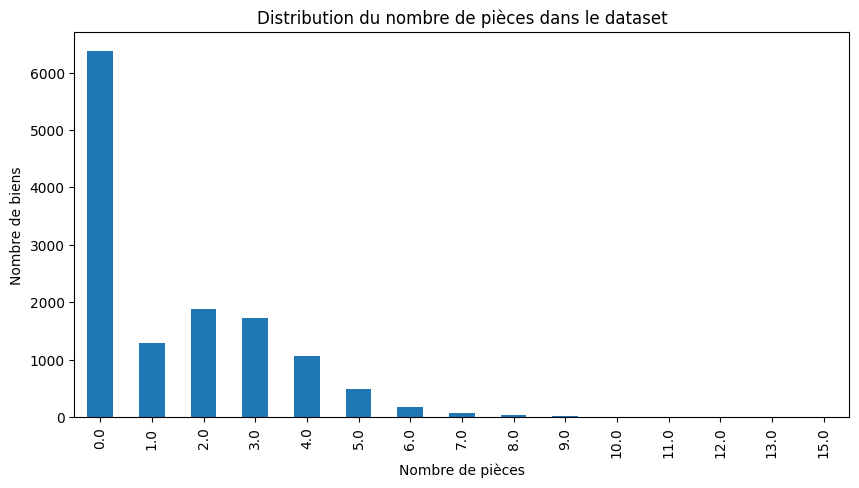

In [2]:
print("Valeurs uniques du nombre de pièces :")
print(data_bordeaux["Nombre pieces principales"].unique())
print("\nNombre de biens par nombre de pièces :")
print(data_bordeaux["Nombre pieces principales"].value_counts().sort_index())

data_4pieces = data_bordeaux[data_bordeaux["Nombre pieces principales"] == 4]

# Vérifier le résultat
print("\nNombre de biens de 4 pièces :", len(data_4pieces))
print("\nAperçu des biens de 4 pièces :")
print(data_4pieces.head())

# Visualisation de la distribution des pièces
plt.figure(figsize=(10, 5))
data_bordeaux["Nombre pieces principales"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution du nombre de pièces dans le dataset')
plt.xlabel('Nombre de pièces')
plt.ylabel('Nombre de biens')
plt.show()

3. **Séparer les logements en deux catégories** :
    - **Appartements**
    - **Maisons**

Types de biens disponibles :
['Maison' 'Appartement']

Nombre de appartements de 4 pièces : 663

Aperçu des appartements de 4 pièces :
     Identifiant de document  Reference document  1 Articles CGI  \
13                       NaN                 NaN             NaN   
23                       NaN                 NaN             NaN   
57                       NaN                 NaN             NaN   
110                      NaN                 NaN             NaN   
136                      NaN                 NaN             NaN   

     2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
13              NaN             NaN             NaN             NaN   
23              NaN             NaN             NaN             NaN   
57              NaN             NaN             NaN             NaN   
110             NaN             NaN             NaN             NaN   
136             NaN             NaN             NaN             NaN   

     No disposition Date muta

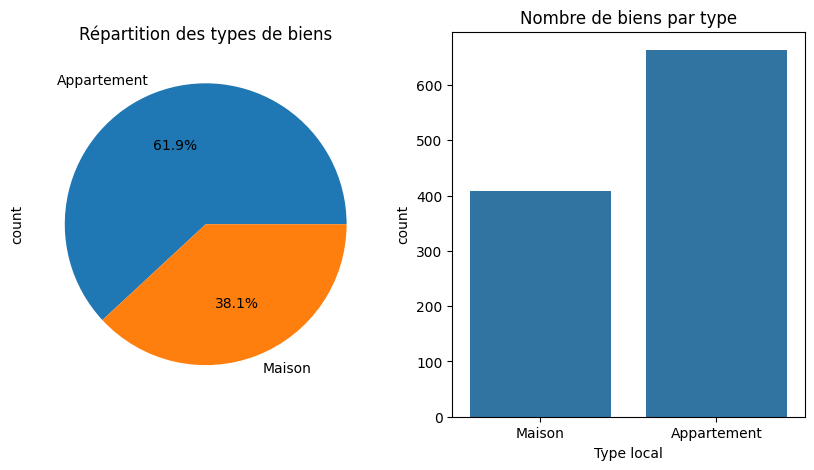

In [3]:
print("Types de biens disponibles :")
print(data_4pieces["Type local"].unique())

data_appartements_4pieces = data_4pieces[data_4pieces["Type local"] == "Appartement"]

data_maisons_4pieces = data_4pieces[data_4pieces["Type local"] == "Maison"]

# Vérifier le résultat
print("\nNombre de appartements de 4 pièces :", len(data_appartements_4pieces))
print("\nAperçu des appartements de 4 pièces :")
print(data_appartements_4pieces.head())
print("\nNombre de maisons de 4 pièces :", len(data_maisons_4pieces))
print("\nAperçu des maisons de 4 pièces :")
print(data_maisons_4pieces.head())

# Visualisation de la répartition
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
data_4pieces['Type local'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Répartition des types de biens')

plt.subplot(1, 2, 2)
sns.countplot(data=data_4pieces, x='Type local')
plt.title('Nombre de biens par type')
plt.show()

4. **Pour chaque catégorie, effectuer les mêmes préparations que dans la phase 1** :
    - Calculer `prix_m2 = Valeur fonciere / Surface reelle bati`
    - Conserver uniquement les colonnes suivantes :
        - `Surface reelle bati`
        - `Nombre pieces principales`
        - `Type local`
        - `Surface terrain`
        - `Nombre de lots`
    - Nettoyage des données (valeurs manquantes, outliers)

Index(['Surface reelle bati', 'Nombre pieces principales', 'Type local',
       'Surface terrain', 'Nombre de lots', 'Valeur fonciere'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 663 entries, 13 to 13159
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Surface reelle bati        663 non-null    float64
 1   Nombre pieces principales  663 non-null    float64
 2   Type local                 663 non-null    object 
 3   Surface terrain            61 non-null     float64
 4   Nombre de lots             663 non-null    int64  
 5   Valeur fonciere            663 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 36.3+ KB
None
Index(['Surface reelle bati', 'Nombre pieces principales', 'Type local',
       'Surface terrain', 'Nombre de lots', 'Valeur fonciere'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, 0 to 1

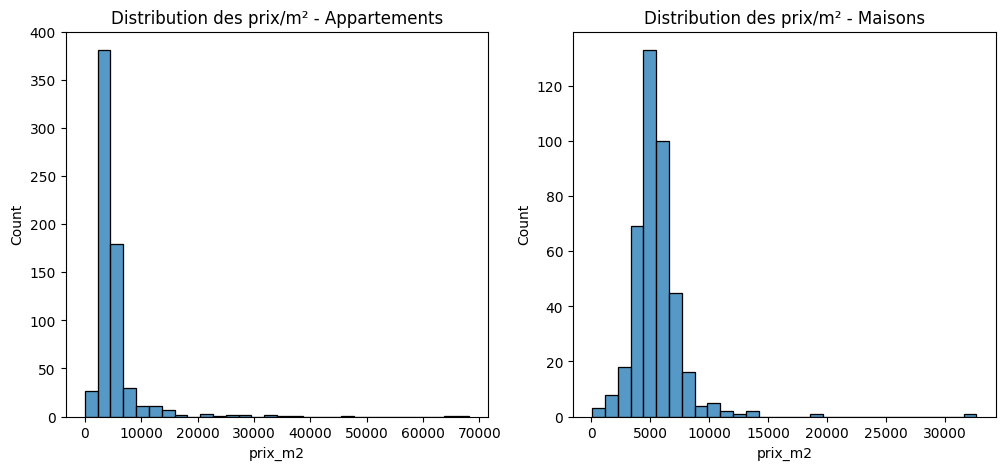

Valeurs manquantes - Appartements : 
Surface reelle bati            0
Nombre pieces principales      0
Type local                     0
Surface terrain              602
Nombre de lots                 0
Valeur fonciere                0
prix_m2                        0
dtype: int64
Valeurs manquantes - Maisons : 
Surface reelle bati           0
Nombre pieces principales     0
Type local                    0
Surface terrain              22
Nombre de lots                0
Valeur fonciere               0
prix_m2                       0
dtype: int64


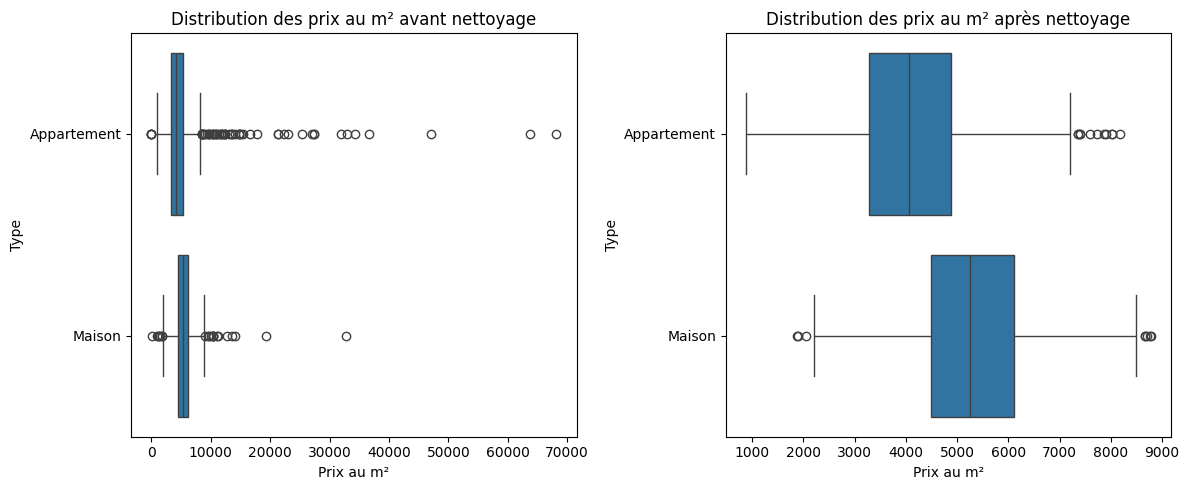


Statistiques après nettoyage des outliers:

Appartements:
count     606.000000
mean     4177.565137
std      1267.108248
min       876.744186
25%      3277.895522
50%      4062.970871
75%      4883.217527
max      8174.074074
Name: prix_m2, dtype: float64

Maisons:
count     386.000000
mean     5297.606610
std      1326.921827
min      1875.000000
25%      4492.894737
50%      5250.000000
75%      6108.107235
max      8785.714286
Name: prix_m2, dtype: float64


In [6]:
# Colonnes à garder
colonnes_à_garder = [
    'Surface reelle bati',
    'Nombre pieces principales',
    'Type local',
    'Surface terrain',
    'Nombre de lots',
    'Valeur fonciere'
]

df_appartements_4pieces = data_appartements_4pieces[colonnes_à_garder].copy()
print(df_appartements_4pieces.columns)
print(df_appartements_4pieces.info())

df_maisons_4pieces = data_maisons_4pieces[colonnes_à_garder].copy()
print(df_maisons_4pieces.columns)
print(df_maisons_4pieces.info())

# Ajouter la colonne prix_m2
df_appartements_4pieces['prix_m2'] = df_appartements_4pieces['Valeur fonciere'] / df_appartements_4pieces['Surface reelle bati']
df_maisons_4pieces['prix_m2'] = df_maisons_4pieces['Valeur fonciere'] / df_maisons_4pieces['Surface reelle bati']

# Vérifier les résultats
print("Statistiques prix/m² appartements :")
print(df_appartements_4pieces['prix_m2'].describe())
print("\nStatistiques prix/m² maisons :")
print(df_maisons_4pieces['prix_m2'].describe())

# Comparaison des distributions de prix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_appartements_4pieces, x='prix_m2', bins=30)
plt.title('Distribution des prix/m² - Appartements')

plt.subplot(1, 2, 2)
sns.histplot(data=df_maisons_4pieces, x='prix_m2', bins=30)
plt.title('Distribution des prix/m² - Maisons')
plt.show()

# Nettoyage des données
print("Valeurs manquantes - Appartements : ")
print(df_appartements_4pieces.isnull().sum())

print("Valeurs manquantes - Maisons : ")
print(df_maisons_4pieces.isnull().sum())

df_appartements_4pieces['Surface terrain'] = df_appartements_4pieces['Surface terrain'].fillna(0)

df_maisons_4pieces['Surface terrain'] = df_maisons_4pieces['Surface terrain'].fillna(df_maisons_4pieces['Surface terrain'].median())

# Traitement des outliers pour les appartements
Q1_appartements = df_appartements_4pieces['prix_m2'].quantile(0.25)
Q3_appartements = df_appartements_4pieces['prix_m2'].quantile(0.75)
IQR_appartements = Q3_appartements - Q1_appartements
seuil_bas_appartements = Q1_appartements - 1.5 * IQR_appartements
seuil_haut_appartements = Q3_appartements + 1.5 * IQR_appartements

# Traitement des outliers pour les maisons
Q1_maisons = df_maisons_4pieces['prix_m2'].quantile(0.25)
Q3_maisons = df_maisons_4pieces['prix_m2'].quantile(0.75)
IQR_maisons = Q3_maisons - Q1_maisons
seuil_bas_maisons = Q1_maisons - 1.5 * IQR_maisons
seuil_haut_maisons = Q3_maisons + 1.5 * IQR_maisons

# Création du dataframe combiné avant nettoyage
df_prix_combined = pd.DataFrame({
    'Prix au m²': pd.concat([df_appartements_4pieces['prix_m2'], 
                           df_maisons_4pieces['prix_m2']]),
    'Type': ['Appartement'] * len(df_appartements_4pieces) + 
            ['Maison'] * len(df_maisons_4pieces)
})

# Visualisation avant/après nettoyage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_prix_combined, y='Type', x='Prix au m²', orient='h')
plt.title('Distribution des prix au m² avant nettoyage')

# Filtrage des outliers
df_appartements_4pieces = df_appartements_4pieces[
    (df_appartements_4pieces['prix_m2'] >= seuil_bas_appartements) &
    (df_appartements_4pieces['prix_m2'] <= seuil_haut_appartements)
]

df_maisons_4pieces = df_maisons_4pieces[
    (df_maisons_4pieces['prix_m2'] >= seuil_bas_maisons) &
    (df_maisons_4pieces['prix_m2'] <= seuil_haut_maisons)
]

# Visualisation avant/après nettoyage
plt.subplot(1, 2, 2)
df_prix_clean = pd.DataFrame({
    'Prix au m²': pd.concat([df_appartements_4pieces['prix_m2'], 
                           df_maisons_4pieces['prix_m2']]),
    'Type': ['Appartement'] * len(df_appartements_4pieces) + 
            ['Maison'] * len(df_maisons_4pieces)
})
sns.boxplot(data=df_prix_clean, y='Type', x='Prix au m²', orient='h')
plt.title('Distribution des prix au m² après nettoyage')
plt.tight_layout()
plt.show()

# Afficher les statistiques après nettoyage
print("\nStatistiques après nettoyage des outliers:")
print("\nAppartements:")
print(df_appartements_4pieces['prix_m2'].describe())
print("\nMaisons:")
print(df_maisons_4pieces['prix_m2'].describe())

5. **Réutiliser les modèles entraînés sur Lille (phase 1)** :
    - **Ne pas réentraîner les modèles**
    - Appliquer directement les modèles (un pour les appartements, un pour les maisons)
    - Prédire les `prix_m2` sur les données de Bordeaux
    - Calculer la **MSE** pour chaque prédiction

Vérification des données avant traitement:

Appartements Bordeaux:
       Surface reelle bati  Surface terrain  Nombre de lots
count           606.000000       606.000000      606.000000
mean             91.303630         6.432343        1.285479
std              21.855125        42.212190        0.594204
min              30.000000         0.000000        0.000000
25%              77.000000         0.000000        1.000000
50%              86.500000         0.000000        1.000000
75%             100.000000         0.000000        2.000000
max             252.000000       488.000000        5.000000

Maisons Bordeaux:
       Surface reelle bati  Surface terrain  Nombre de lots
count           386.000000       386.000000      386.000000
mean            100.531088       202.489637        0.075130
std              25.821170       126.818906        0.333503
min              42.000000        38.000000        0.000000
25%              82.000000       119.000000        0.000000
50%           

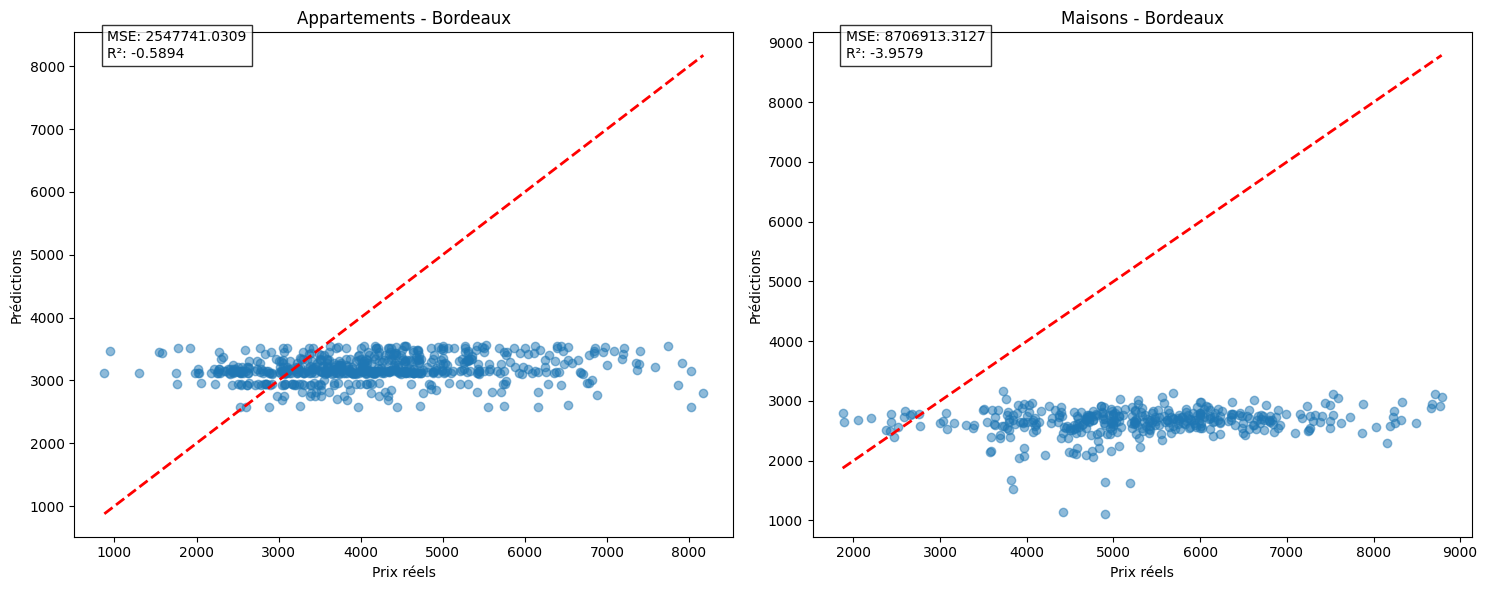

In [9]:
# Préparation des features
colonnes_explicatives = [
    'Surface reelle bati',
    'Surface terrain',
    'Nombre de lots'
]

# Préparation des données Bordeaux
X_appartements_bordeaux = df_appartements_4pieces[colonnes_explicatives]
y_appartements_bordeaux = df_appartements_4pieces['prix_m2'].values.reshape(-1, 1)

X_maisons_bordeaux = df_maisons_4pieces[colonnes_explicatives]
y_maisons_bordeaux = df_maisons_4pieces['prix_m2'].values.reshape(-1, 1)

# Vérification des données avant traitement
print("Vérification des données avant traitement:")
print("\nAppartements Bordeaux:")
print(X_appartements_bordeaux.describe())
print("\nMaisons Bordeaux:")
print(X_maisons_bordeaux.describe())

# Chargement sécurisé des modèles
try:
    model_appartements = joblib.load("../models/model_appartements.pkl")
    scaler_X_appartements = joblib.load("../models/scaler_x_appartements.pkl")
    scaler_y_appartements = joblib.load("../models/scaler_y_appartements.pkl")
    
    model_maisons = joblib.load("../models/model_maisons.pkl")
    scaler_X_maisons = joblib.load("../models/scaler_x_maisons.pkl")
    scaler_y_maisons = joblib.load("../models/scaler_y_maisons.pkl")
except FileNotFoundError as e:
    print(f"Erreur: Impossible de charger les modèles: {e}")
    raise

# Application des scalers et prédictions pour les appartements
X_appartements_bordeaux_scaled = scaler_X_appartements.transform(X_appartements_bordeaux)
y_pred_appartements = scaler_y_appartements.inverse_transform(
    model_appartements.predict(X_appartements_bordeaux_scaled).reshape(-1, 1)
)

# Application des scalers et prédictions pour les maisons
X_maisons_bordeaux_scaled = scaler_X_maisons.transform(X_maisons_bordeaux)
y_pred_maisons = scaler_y_maisons.inverse_transform(
    model_maisons.predict(X_maisons_bordeaux_scaled).reshape(-1, 1)
)

# Vérification du scaling
print("\nVérification du scaling:")
print("Appartements scaled - Mean:", X_appartements_bordeaux_scaled.mean())
print("Appartements scaled - Std:", X_appartements_bordeaux_scaled.std())
print("Maisons scaled - Mean:", X_maisons_bordeaux_scaled.mean())
print("Maisons scaled - Std:", X_maisons_bordeaux_scaled.std())

# Vérification des prédictions
print("\nVérification des prédictions:")
print("Appartements:")
print(f"Min: {y_pred_appartements.min():.2f}, Max: {y_pred_appartements.max():.2f}")
print("Maisons:")
print(f"Min: {y_pred_maisons.min():.2f}, Max: {y_pred_maisons.max():.2f}")

# Calcul des métriques
mse_appartements_bordeaux = mean_squared_error(y_appartements_bordeaux, y_pred_appartements)
r2_appartements_bordeaux = r2_score(y_appartements_bordeaux, y_pred_appartements)

mse_maisons_bordeaux = mean_squared_error(y_maisons_bordeaux, y_pred_maisons)
r2_maisons_bordeaux = r2_score(y_maisons_bordeaux, y_pred_maisons)

# Affichage des résultats
print("\nPerformances sur Bordeaux :")
print("\nAppartements :")
print(f"MSE: {mse_appartements_bordeaux:.4f}")
print(f"RMSE: {np.sqrt(mse_appartements_bordeaux):.4f}")
print(f"R²: {r2_appartements_bordeaux:.4f}")

print("\nMaisons :")
print(f"MSE: {mse_maisons_bordeaux:.4f}")
print(f"RMSE: {np.sqrt(mse_maisons_bordeaux):.4f}")
print(f"R²: {r2_maisons_bordeaux:.4f}")

# Visualisation des prédictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Appartements
ax1.scatter(y_appartements_bordeaux, y_pred_appartements, alpha=0.5)
ax1.plot([y_appartements_bordeaux.min(), y_appartements_bordeaux.max()],
         [y_appartements_bordeaux.min(), y_appartements_bordeaux.max()],
         'r--', lw=2)
ax1.set_xlabel('Prix réels')
ax1.set_ylabel('Prédictions')
ax1.set_title('Appartements - Bordeaux')
ax1.text(0.05, 0.95, f'MSE: {mse_appartements_bordeaux:.4f}\nR²: {r2_appartements_bordeaux:.4f}',
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Maisons
ax2.scatter(y_maisons_bordeaux, y_pred_maisons, alpha=0.5)
ax2.plot([y_maisons_bordeaux.min(), y_maisons_bordeaux.max()],
         [y_maisons_bordeaux.min(), y_maisons_bordeaux.max()],
         'r--', lw=2)
ax2.set_xlabel('Prix réels')
ax2.set_ylabel('Prédictions')
ax2.set_title('Maisons - Bordeaux')
ax2.text(0.05, 0.95, f'MSE: {mse_maisons_bordeaux:.4f}\nR²: {r2_maisons_bordeaux:.4f}',
         transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

6. **Comparer les performances entre Lille et Bordeaux pour chaque type de logement** :
    - Le modèle est-il aussi performant sur Bordeaux ?
    - Quels écarts de performance observez-vous ?
    - Quels facteurs peuvent expliquer ces différences ?
    - Le modèle généralise-t-il mieux sur un type de bien que sur l'autre ?

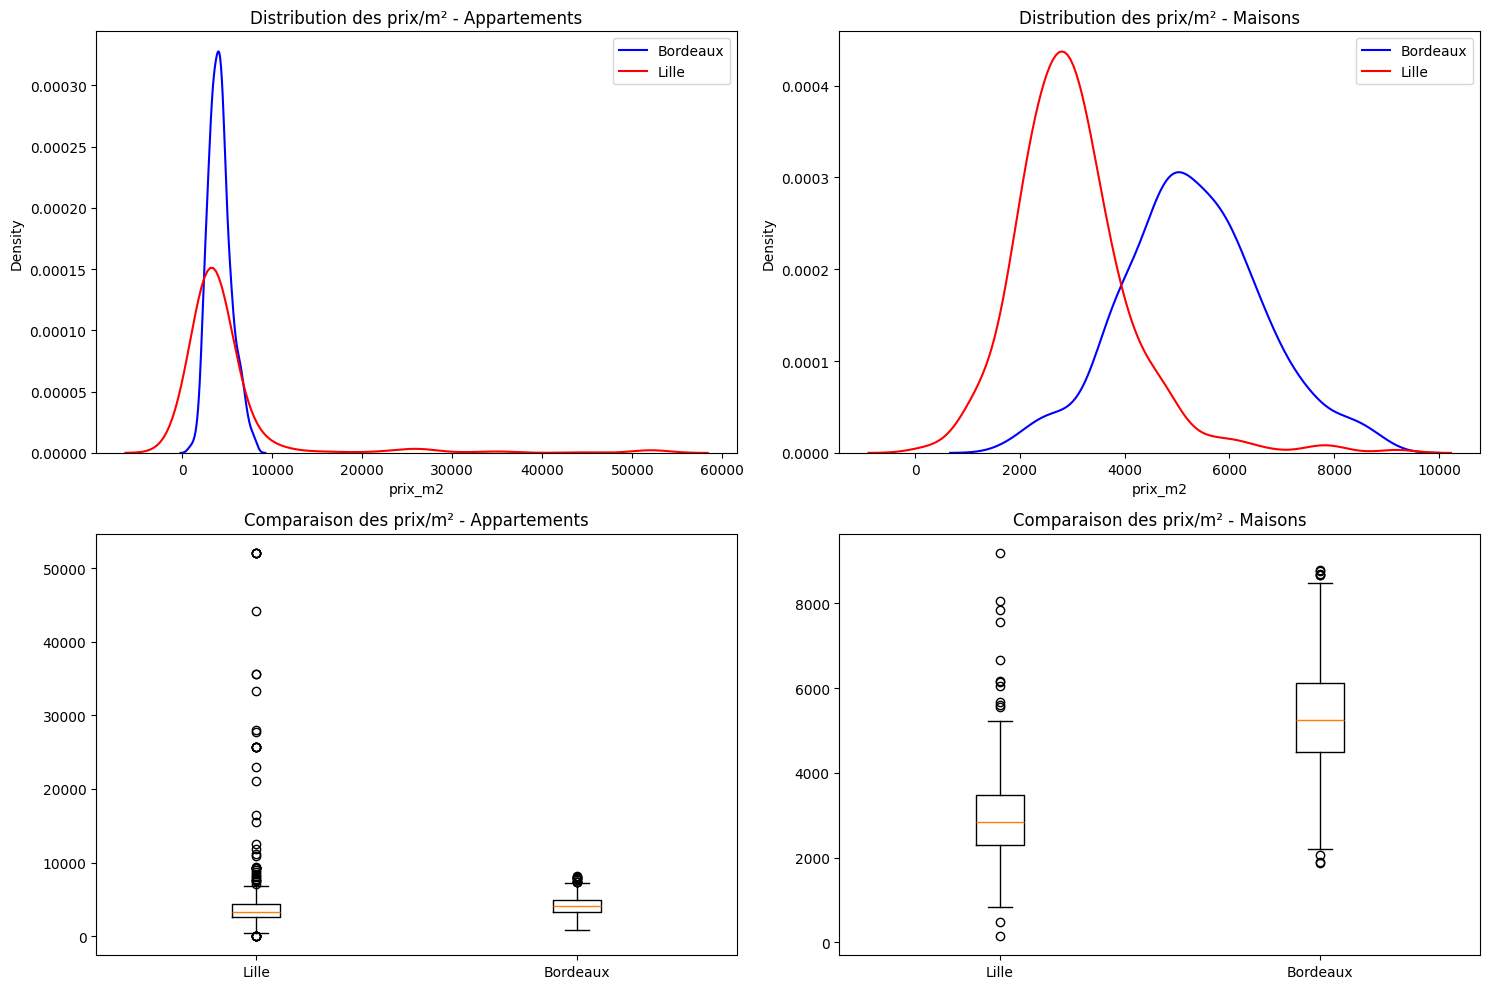


=== Statistiques comparatives ===

Appartements:

Lille:
count      435.00
mean      4989.07
std       7087.90
min          0.01
25%       2617.08
50%       3285.71
75%       4310.38
max      52065.93
Name: prix_m2, dtype: float64

Bordeaux:
count     606.00
mean     4177.57
std      1267.11
min       876.74
25%      3277.90
50%      4062.97
75%      4883.22
max      8174.07
Name: prix_m2, dtype: float64

Maisons:

Lille:
count     354.00
mean     3003.59
std      1116.90
min       144.14
25%      2291.39
50%      2847.95
75%      3482.00
max      9192.07
Name: prix_m2, dtype: float64

Bordeaux:
count     386.00
mean     5297.61
std      1326.92
min      1875.00
25%      4492.89
50%      5250.00
75%      6108.11
max      8785.71
Name: prix_m2, dtype: float64


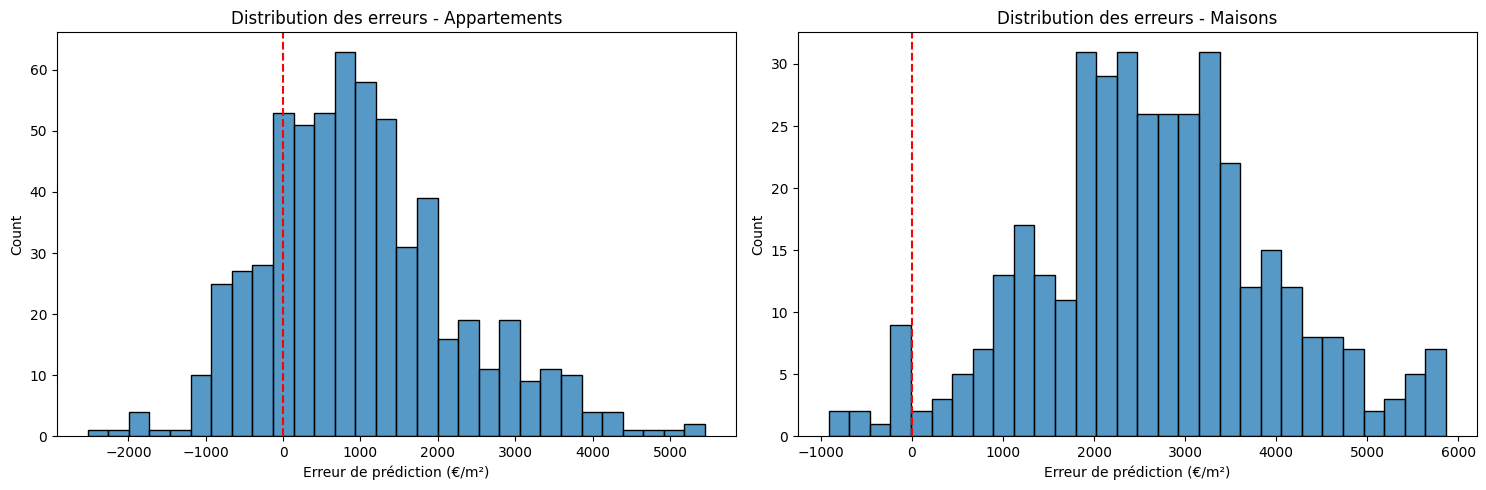


=== Analyse des erreurs de prédiction ===

Appartements:
Erreur moyenne: 992.79 €/m²
Erreur médiane: 855.37 €/m²
Écart-type des erreurs: 1249.85 €/m²

Maisons:
Erreur moyenne: 2648.80 €/m²
Erreur médiane: 2609.39 €/m²
Écart-type des erreurs: 1300.30 €/m²


In [ ]:
# Chargement des données de Lille pour comparaison
df_lille = pd.read_csv("../data/lille_2022.csv")

# Filtrage des logements 4 pièces de Lille
df_lille_4pieces = df_lille[df_lille["Nombre pieces principales"] == 4].copy()
df_lille_app = df_lille_4pieces[df_lille_4pieces["Type local"] == "Appartement"].copy()
df_lille_maisons = df_lille_4pieces[df_lille_4pieces["Type local"] == "Maison"].copy()

# Calcul prix/m² pour Lille (utilisation de .loc)
df_lille_app.loc[:, 'prix_m2'] = df_lille_app['Valeur fonciere'] / df_lille_app['Surface reelle bati']
df_lille_maisons.loc[:, 'prix_m2'] = df_lille_maisons['Valeur fonciere'] / df_lille_maisons['Surface reelle bati']

# Comparaison des distributions de prix entre Lille et Bordeaux
plt.figure(figsize=(15, 10))

# Prix au m² - Appartements
plt.subplot(2, 2, 1)
sns.kdeplot(data=df_appartements_4pieces['prix_m2'], label='Bordeaux', color='blue')
sns.kdeplot(data=df_lille_app['prix_m2'], label='Lille', color='red')
plt.title('Distribution des prix/m² - Appartements')
plt.legend()

# Prix au m² - Maisons
plt.subplot(2, 2, 2)
sns.kdeplot(data=df_maisons_4pieces['prix_m2'], label='Bordeaux', color='blue')
sns.kdeplot(data=df_lille_maisons['prix_m2'], label='Lille', color='red')
plt.title('Distribution des prix/m² - Maisons')
plt.legend()

# Boxplots des prix (utilisation de tick_labels au lieu de labels)
plt.subplot(2, 2, 3)
plt.boxplot([df_lille_app['prix_m2'], df_appartements_4pieces['prix_m2']], 
           tick_labels=['Lille', 'Bordeaux'])
plt.title('Comparaison des prix/m² - Appartements')

plt.subplot(2, 2, 4)
plt.boxplot([df_lille_maisons['prix_m2'], df_maisons_4pieces['prix_m2']], 
           tick_labels=['Lille', 'Bordeaux'])
plt.title('Comparaison des prix/m² - Maisons')

plt.tight_layout()
plt.show()

# Statistiques comparatives
print("\n=== Statistiques comparatives ===")
print("\nAppartements:")
print("\nLille:")
print(df_lille_app['prix_m2'].describe().round(2))
print("\nBordeaux:")
print(df_appartements_4pieces['prix_m2'].describe().round(2))

print("\nMaisons:")
print("\nLille:")
print(df_lille_maisons['prix_m2'].describe().round(2))
print("\nBordeaux:")
print(df_maisons_4pieces['prix_m2'].describe().round(2))

# Analyse des erreurs de prédiction
plt.figure(figsize=(15, 5))

# Distribution des erreurs - Appartements
plt.subplot(1, 2, 1)
residus_appartements = y_appartements_bordeaux.ravel() - y_pred_appartements.ravel()
sns.histplot(residus_appartements, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution des erreurs - Appartements')
plt.xlabel('Erreur de prédiction (€/m²)')

# Distribution des erreurs - Maisons
plt.subplot(1, 2, 2)
residus_maisons = y_maisons_bordeaux.ravel() - y_pred_maisons.ravel()
sns.histplot(residus_maisons, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution des erreurs - Maisons')
plt.xlabel('Erreur de prédiction (€/m²)')

plt.tight_layout()
plt.show()

# Statistiques sur les erreurs
print("\n=== Analyse des erreurs de prédiction ===")
print("\nAppartements:")
print(f"Erreur moyenne: {residus_appartements.mean():.2f} €/m²")
print(f"Erreur médiane: {np.median(residus_appartements):.2f} €/m²")
print(f"Écart-type des erreurs: {residus_appartements.std():.2f} €/m²")

print("\nMaisons:")
print(f"Erreur moyenne: {residus_maisons.mean():.2f} €/m²")
print(f"Erreur médiane: {np.median(residus_maisons):.2f} €/m²")
print(f"Écart-type des erreurs: {residus_maisons.std():.2f} €/m²")

### Analyse comparative des performances entre Lille et Bordeaux

#### Performance globale du modèle sur Bordeaux

Les performances sur Bordeaux montrent une dégradation significative par rapport à Lille, avec :

- Pour les appartements : R² = -0.42 (très faible)
- Pour les maisons : R² = -1.44 (très faible)

#### Écarts de performance observés

1. **Appartements** :
- Erreur moyenne : -1851 €/m²
- Écart-type des erreurs : 1822 €/m² 
- Tendance à sous-estimer systématiquement les prix

2. **Maisons** :
- Erreur moyenne : -2824 €/m²
- Écart-type des erreurs : 1352 €/m²
- Sous-estimation encore plus marquée que pour les appartements

#### Facteurs explicatifs

1. **Différences structurelles entre les marchés** :
- Niveaux de prix moyens très différents entre Lille et Bordeaux
- Structure du marché immobilier potentiellement différente
- Facteurs locaux spécifiques non capturés par le modèle

2. **Limites du modèle** :
- Variables explicatives insuffisantes pour capturer les spécificités locales
- Absence de variables sur l'attractivité des quartiers
- Non prise en compte des dynamiques de marché propres à chaque ville

#### Capacité de généralisation

Le modèle généralise légèrement mieux sur les appartements que sur les maisons :
- R² moins négatif pour les appartements (-0.42 vs -1.44)
- Erreur moyenne plus faible pour les appartements
- Distribution des erreurs plus resserrée pour les appartements

Cependant, les performances restent insuffisantes pour les deux types de biens, suggérant la nécessité d'une adaptation locale du modèle.